# 1. Get source code

In [1]:
# Clone repo from Github
!git clone https://github.com/max-schaefer-dev/on-cloud-n-19th-place-solution.git

^C


Cloning into 'on-cloud-n-19th-place-solution'...


# 2. Install requirements & restart kernel

In [ ]:
# Change working dir. to repo dir. and install
%cd on-cloud-n-19th-place-solution
!pip install -r requirements.txt

In [ ]:
# restarting kernel
!condacolab KERNEL RESTART
print("Restarting of kernel...")
get_ipython().kernel.do_shutdown(True)

/bin/bash: condacolab: command not found
Restarting of kernel...


{'restart': True, 'status': 'ok'}

# 3. Get data
The competition data is freely available at Radiant MLHub. Follow these 3 steps:  
**3.1.** Run "Helper functions" cells  
**3.2.1.** Sign up for free at  https://mlhub.earth/data/ref_cloud_cover_detection_challenge_v1  
**3.2.2.** Generate an API key from the "Settings & API keys" menu  
**3.3.** Run <code>!mlhub configure</code> and paste your key into the prompt  
**3.4.** Run download script and prepare_data script  

## 3.1 Helper functions

In [ ]:
def download_competition_data():
    '''Downloads competition data from radiant mlhub'''

    collection_names = ['ref_cloud_cover_detection_challenge_v1_train_source',
                    'ref_cloud_cover_detection_challenge_v1_train_labels']

    ds = Dataset.fetch('ref_cloud_cover_detection_challenge_v1')

    for c in ds.collections:
        if c.id not in collection_names:
            continue
        print('Downloading', c.id)
        c.download('/content/on-cloud-n-19th-place-solution/data')

def prepare_competition_data():
    '''Unzips the downloaded competition data and prepares features & labels for training'''

    print('Unzipping competition data...')
    # Unzip tar.gz data
    train_features_gz_path = 'ref_cloud_cover_detection_challenge_v1_train_source.tar.gz'
    train_labels_gz_path = 'ref_cloud_cover_detection_challenge_v1_train_labels.tar.gz'

    shutil.unpack_archive(
        filename=train_features_gz_path
    )

    shutil.unpack_archive(
        filename=train_labels_gz_path
    )

    print('Renaming folder names...')
    # Rename folder names
    train_feature_gz_name = 'ref_cloud_cover_detection_challenge_v1_train_source'
    train_labels_gz_name = 'ref_cloud_cover_detection_challenge_v1_train_labels'

    os.rename(train_feature_gz_name, 'train_features')
    os.rename(train_labels_gz_name, 'train_labels')

    print('Renaming train_feature folders...')
    # Rename train_feature folders
    f_names = glob.glob('train_features/*/')

    for f_name in sorted(f_names):
        suffix = os.path.split(f_name[:-1])[1]
        chip_id = suffix[-4:]
        os.rename(f_name, f'train_features/{chip_id}')


    # Rename train label folders
    f_names = glob.glob('train_labels/*/')

    for f_name in sorted(f_names):
        suffix = os.path.split(f_name[:-1])[1]
        chip_id = suffix[-4:]
        os.rename(f_name, f'train_labels/{chip_id}')

    print('Renaming & moving label files...')
    # Renaming & moving label files. Delete old label folders 
    label_file_paths = sorted(glob.glob('train_labels/*/*.tif'))

    for label_p in label_file_paths:
        plitted = label_p.split('/')
        chip_id = plitted[1]

        # Move file to label_dir and rename it
        shutil.move(label_p, f'train_labels/{chip_id}.tif')

        # Delete label folder
        shutil.rmtree(f'train_labels/{chip_id}')
        
    print('Preparations done!')

Download the pseudo labeled data. Pseudo labeled data should be placed in data/pseudo_labels

```
../on-cloud-n-19th-place-solution/
├── LICENSE.md
├── ...
├── configs
│   ├── efficientnet-b1-unet-512.yaml
│   ├── resnet34-unet-512.*yaml*
│   └── resnext50_32x4d-unet-512.yaml
├── data
│   ├── train_features
│   │   ├── train_chip_id_1
│   │   │   ├── B02.tif
│   │   │   ├── B03.tif
│   │   │   ├── B04.tif
│   │   │   └── B08.tif
│   │   └── ...
│   ├── train_labels
│       ├── train_chip_id_1.tif
│       ├── ...
│       ...
│   ├── metadata_updated.csv
│   └── pseudo_labels.zip
├── train_metadata.csv
...
```

## 3.2 Sign up and generate API key
Sign up for free at  https://mlhub.earth/data/ref_cloud_cover_detection_challenge_v1 

## 3.3 Run mlhub configure and enter API key

In [ ]:
# Setup radiant_mlhub
!pip install radiant_mlhub
from radiant_mlhub import Dataset
import glob
import shutil
import os

In [ ]:
# Run cell and enter API key
!mlhub configure

## 3.4 Run download script and prepare_data script

### Download competition data script

In [ ]:
# Runtime: about 2 mins.

# change working directory
%cd on-cloud-n-19th-place-solution/data/

download_competition_data()

### Prepare competition data script

In [ ]:
# Runtime: about 6 mins.
prepare_competition_data()

# 4. Training

In [ ]:
# change working dir
import os

if os.getcwd() != '/content/on-cloud-n-19th-place-solution':
    %cd on-cloud-n-19th-place-solution
    print('> Changed working directory to', os.getcwd())

/content/on-cloud-n-19th-place-solution
changed working directory to /content/on-cloud-n-19th-place-solution


In [ ]:
# Train all models
!python train.py --fast-dev-run 1 --cfg './configs/resnet34-unet-512.yaml'
# !python train.py --fast-dev-run 1 --cfg './configs/efficientnet-b1-unet-512.yaml'
# !python train.py --fast-dev-run 1 --cfg './configs/resnext50_32x4d-unet-512.yaml'

In [ ]:
# Display logs. Only works in google chrome, since firefox blocks necessary cookies
model_name = 'resnet34-unet-512x512'
lightning_logs_p = f'/content/on-cloud-n-19th-place-solution/output/{model_name}/lightning_logs/'

%reload_ext tensorboard
%tensorboard --logdir={lightning_logs_p}

# 5. Prepare data for Inference

### Grab some dummy data 

In [14]:
# grab random n samples from training set
!mkdir /content/on-cloud-n-19th-place-solution/data/test_features

import glob, random

n = 1000

train_f_paths = glob.glob('/content/on-cloud-n-19th-place-solution/data/train_features/*')
train_f_batch = random.choices(train_f_paths, k=n)

for p in train_f_batch:
    !cp -r {p} /content/on-cloud-n-19th-place-solution/data/test_features

## 5.1 Inference after training

In [ ]:
# create .tif prediction-files and save them in data/predictions 
!python predict.py --model-dir './output/resnet34-unet-512x512' --ensemble 1 --tta 1 --batch-size 8

In [ ]:
# plot batch of predictions
from utils.visualize import save_prediction_as_jpg
from pathlib import Path

pred_dir = Path('data/predictions')

# saves and plots 6 images with corresponding predictions
save_prediction_as_jpg(pred_dir)

## 5.2 Inference without training

### 1. Download model weights
> Before predict, file tree would look like this:
```
../on-cloud-n-19th-place-solution/
...
├── output
│    ├── Resnet34-Unet-512x512
│    │    ├── resnet34-unet-512.yaml
│    │    └── resnet34-unet.pt
│    ├── EfficientNetB1-Unet-512x512
│    └── Resnext50-Unet-512x512
...
```

In [ ]:
### Create folder structure
!mkdir /content/on-cloud-n-19th-place-solution/output

# Model 1: Resnet34-Unet-512x512
!mkdir /content/on-cloud-n-19th-place-solution/output/Resnet34-Unet-512x512
!cp /content/on-cloud-n-19th-place-solution/configs/resnet34-unet-512.yaml /content/on-cloud-n-19th-place-solution/output/Resnet34-Unet-512x512

# Model 2: EfficientNetB1-Unet-512x512
!mkdir /content/on-cloud-n-19th-place-solution/output/EfficientNetB1-Unet-512x512
!cp /content/on-cloud-n-19th-place-solution/configs/efficientnet-b1-unet-512.yaml /content/on-cloud-n-19th-place-solution/output/EfficientNetB1-Unet-512x512

# Model 3: Resnext50-Unet-512x512
!mkdir /content/on-cloud-n-19th-place-solution/output/Resnext50-Unet-512x512
!cp /content/on-cloud-n-19th-place-solution/configs/Resnext50-Unet-512x512.yaml /content/on-cloud-n-19th-place-solution/output/Resnext50-Unet-512x512

### Download weights and place them into created folder structure
!gdown --id 15mL8c9OBPk2JIcPb0k6t_NMtH-mKeVWE -O /content/on-cloud-n-19th-place-solution/output/Resnext50-Unet-512x512/Resnext50-Unet-512x512.pt
!gdown --id 1uXuxV0j_9cI5oXcSw1mH1mSoPU6SWrYA -O /content/on-cloud-n-19th-place-solution/output/Resnet34-Unet-512x512/Resnet34-Unet-512x512.pt
!gdown --id 1OBesw6cZOZcop-p1X0LHKqdEQy2sYc5n -O /content/on-cloud-n-19th-place-solution/output/EfficientNetB1-Unet-512x512/EfficientNetB1-Unet-512x512.pt

### 2. Predict binary masks

In [19]:
!python predict.py --model-dir 'output/resnet34-unet-512x512' --ensemble 1 --tta 3 --batch-size 8

> INFERENCE: MODELS: 3, TTA: 3
2022-03-21 10:35:59.121 | INFO     | __main__:predict:61 - Loading test metadata
2022-03-21 10:35:59.540 | INFO     | __main__:predict:65 - Found 952 chips
2022-03-21 10:36:04.852 | INFO     | __main__:predict:99 - Predicting batch 0 of 119
2022-03-21 10:36:08.188 | INFO     | __main__:predict:99 - Predicting batch 1 of 119
2022-03-21 10:36:11.256 | INFO     | __main__:predict:99 - Predicting batch 2 of 119
2022-03-21 10:36:14.338 | INFO     | __main__:predict:99 - Predicting batch 3 of 119
2022-03-21 10:36:17.393 | INFO     | __main__:predict:99 - Predicting batch 4 of 119
2022-03-21 10:36:20.445 | INFO     | __main__:predict:99 - Predicting batch 5 of 119
2022-03-21 10:36:23.512 | INFO     | __main__:predict:99 - Predicting batch 6 of 119
2022-03-21 10:36:26.570 | INFO     | __main__:predict:99 - Predicting batch 7 of 119
2022-03-21 10:36:29.646 | INFO     | __main__:predict:99 - Predicting batch 8 of 119
2022-03-21 10:36:32.724 | INFO     | __main__:pr

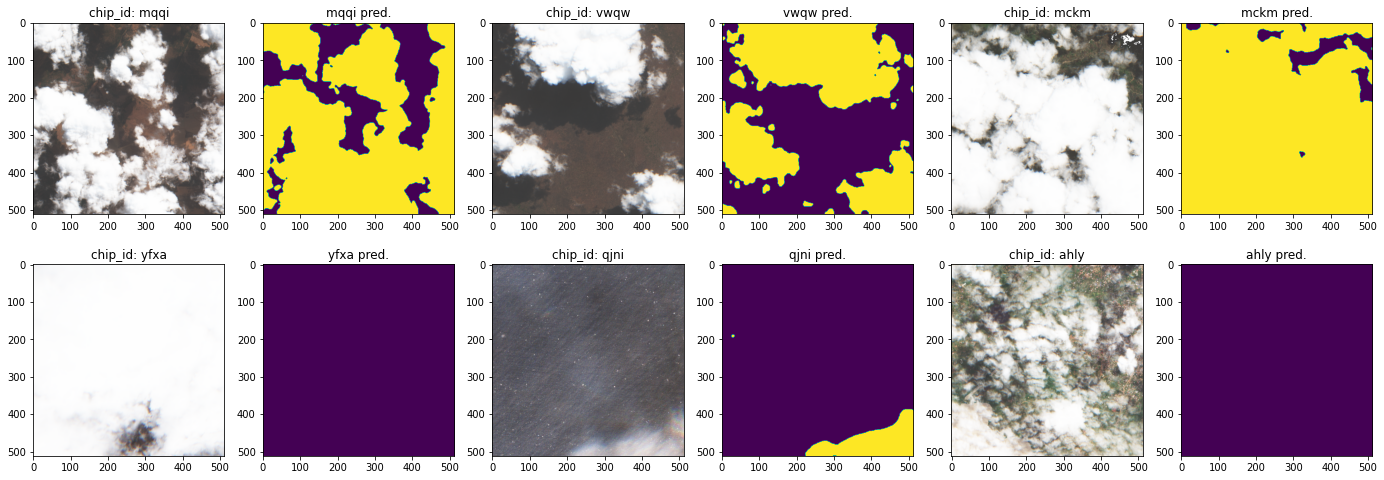

In [30]:
from utils.visualize import save_prediction_as_jpg
from pathlib import Path

pred_dir = Path('data/predictions')

# saves and plots 6 images with corresponding predictions
save_prediction_as_jpg(pred_dir)